In [14]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(1003)

datadir = Path('.').resolve().parents[0] / "data"
datadir

PosixPath('/home/mddevine/projects/ml-wine/data')

## read in the data

In [15]:
df = pd.read_csv(datadir / "processed" / "wine_df_final.csv")
print(f"{len(df)} observations.")
df.head()

178 observations.


,class,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280_over_od315,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [16]:
# features == all columns except the class (our target), and `is_train`
features = df.columns[1:]
features

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue', 'od280_over_od315',
       'proline'],
      dtype='object')

In [17]:
X, y = df[features], df['class']

## train / test split

In [18]:
from collections import namedtuple
Experiment = namedtuple(
    'Experiment',
    ['k', 'train_index', 'test_index', 'clf', 'predictions', 'accuracy'])

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

kf = KFold(n_splits=10, shuffle=True, random_state=9999)
all_experiments = {}
all_accuracies = []
for k, (train_index, test_index) in enumerate(kf.split(X, y)):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    clf = RandomForestClassifier(n_jobs=2, random_state=1003)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, predictions)
    all_accuracies.append(acc)
    all_experiments[k] = Experiment(k, train_index, test_index, clf, predictions, acc)
    print(f"{k=}, {len(train_index)}, {len(test_index)} --> {acc=}")
    
print(f"average accuracy across runs = {round(sum(all_accuracies) / len(all_accuracies), 2)}")

k=0, 160, 18 --> acc=1.0
k=1, 160, 18 --> acc=1.0
k=2, 160, 18 --> acc=1.0
k=3, 160, 18 --> acc=0.9444444444444444
k=4, 160, 18 --> acc=1.0
k=5, 160, 18 --> acc=1.0
k=6, 160, 18 --> acc=0.9444444444444444
k=7, 160, 18 --> acc=0.9444444444444444
k=8, 161, 17 --> acc=1.0
k=9, 161, 17 --> acc=1.0
average accuracy across runs = 0.98


## review the results

In [23]:
for k, exp in all_experiments.items():
    for i, (actual, pred) in enumerate(zip(y.loc[exp.test_index], exp.predictions)):
        if actual != pred:
            print(f"{k=}:{actual=} {pred=}, index={exp.test_index[i]}")

k=3:actual=2 pred=3, index=61
k=6:actual=2 pred=3, index=83
k=7:actual=2 pred=1, index=73


In [24]:
k = 6 #experiment we want to investigate further
exp = all_experiments[k]

print(f"confusion matrix for experiment {k}")
pd.crosstab(y.loc[exp.test_index], exp.predictions, rownames=['Actual Wine'], colnames=['Predicted Wine'])

confusion matrix for experiment 6


Predicted Wine,1,2,3
Actual Wine,,,
1,4,0,0
2,0,6,1
3,0,0,7


## quick look at feature importance

In [25]:
data = []
for k, exp in all_experiments.items():
    data.append(exp.clf.feature_importances_)
    
feat_imp_df = pd.DataFrame(data, columns=features)
feat_imp_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280_over_od315,proline
0,0.120999,0.032635,0.015882,0.030951,0.031953,0.057529,0.119536,0.007221,0.014961,0.177142,0.081005,0.142059,0.168126
1,0.149183,0.022160,0.015384,0.027745,0.031838,0.062508,0.133138,0.010712,0.014528,0.148199,0.097741,0.126917,0.159947
2,0.127505,0.028281,0.019926,0.024444,0.017374,0.074479,0.132356,0.010636,0.014839,0.183913,0.093742,0.134464,0.138043
3,0.124784,0.027086,0.016275,0.030947,0.036167,0.048760,0.144913,0.012618,0.022366,0.151841,0.063570,0.157452,0.163221
4,0.136901,0.029394,0.009477,0.031143,0.025450,0.063666,0.155247,0.017190,0.018896,0.167185,0.071825,0.115440,0.158187


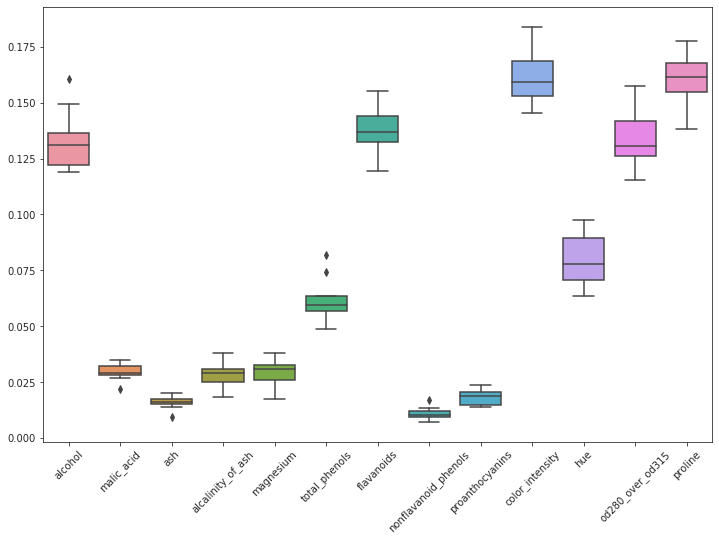

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
chart = sns.boxplot(data=feat_imp_df)    
#chart = sns.swarmplot(data=feat_imp_df, color=".5")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart